In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch
import copy
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
from dnaDataloader import expermentDataloader
import os
import random
import matplotlib.colors as mcolors
from IPython.core.interactiveshell import InteractiveShell
from dnaModelUtil import printStats
from dnaModelUtil import averageDiff
from dnaDataloader import addData
from dnaDataloader import expermentDataloader
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
oneMinInFPS = 1200
device

device(type='cuda', index=3)

# Single-molecule experiment prediction model

This notebook is the step by step development process for making a SNN to predict the reactivity level and number of reactions in Single-molecule experiments
Data is provided via the Kent State University chemistry department. The model development is provided by the Kent State University computer science department

<table style="border:none;padding: 10px;margin: auto;">
    <tr style="border:none;padding: 10px;margin: auto;">
<td style="border:none;padding: 10px;margin: auto;">
    <b>Contacts from the chem dept.</b><br>
            Li Zuo <br>
            Email: lzuo4@kent.edu <br>
            Office: 303B Willems Hall (ISB) <br>
            WeChat: wxid_t2t99eeqkhih22 <br>
            <br>
            Dr. Hao Shen<br>
            Email: hshen7@kent.edu<br>
        </td>
        <td style="border:none;padding: 10px;margin: auto;">
            <b>Contacts from the CS dept.</b><br>
    Kendric Hood<br>
            Email: khood5@kent.edu<br>
            Office: 160 Math and Science Building (MSB)<br>
            WeChat: wxid_m66vu8fc422c12 <br>
            <br>
            Dr. Qiang Guan <br>
            Email: qguan@kent.edu<br>
        </td>
    </tr>
</table>

Working with data from <code>Prepocessing/data/</code> should have folder for each experment setup (in terms of disctance of magnent in mm). Each folder should have a list of events and their frame numbers as excel file. Events are recorded as events per 0.05 secs. The raw excel files are converted to CSV files with preprocess.py.

The processed file are shorted versions of the orignal files, i.e. its only the first X secs. These csv files have a 1 or a 0 for each 0.05 sec inteval. 1 means event 0 menas no event.  The index file has the list of each processed file path and the target (total number of events) they are in. 

- ran for 20 mins ~ 12000 frames
<table>
    <tr>
        <td> folder </td><td>total number of files</td>
    </tr>
    <tr>
        <td> 1.5mm_35.14pN </td><td>27</td>
    </tr>
    <tr>
        <td> 2mm_22.6pN </td><td>29</td>
    </tr>
    <tr>
        <td> 3mm_9.24pN </td><td>16</td>
    </tr>
    <tr>
        <td> 5mm_1.46pN </td><td>63</td>
    </tr>
    <tr>
        <td> 9mm_0.002pN </td><td>21</td>
    </tr>
</table>
 Total number of examples <em>156</em>

In [4]:
datasetlow = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/low/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/low",
    length=10*oneMinInFPS
)
datasetmedium = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/medium/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/medium",
    length=10*oneMinInFPS
)
datasetHigh = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/high/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/high",
    length=10*oneMinInFPS
)

print(f"datasetlow:{len(datasetlow)}")
print(f"datasetmedium:{len(datasetmedium)}")
print(f"datasetHigh:{len(datasetHigh)}")
print(f"Total: {len(datasetlow) + len(datasetmedium) + len(datasetHigh)}")

datasetlow:56
datasetmedium:16
datasetHigh:84
Total: 156


In [5]:
highTargets = [i[1][0] for i in datasetHigh]
mediumTargets = [i[1][0] for i in datasetmedium]
lowTargets = [i[1][0] for i in datasetlow]
highTargets

[339,
 296,
 303,
 283,
 337,
 301,
 305,
 342,
 310,
 321,
 321,
 298,
 392,
 328,
 379,
 340,
 340,
 285,
 274,
 285,
 282,
 105,
 51,
 297,
 191,
 352,
 238,
 80,
 303,
 167,
 103,
 107,
 184,
 379,
 55,
 89,
 484,
 535,
 262,
 113,
 501,
 196,
 179,
 488,
 165,
 327,
 710,
 135,
 87,
 167,
 133,
 258,
 635,
 224,
 53,
 538,
 462,
 311,
 187,
 219,
 57,
 34,
 165,
 446,
 175,
 219,
 363,
 243,
 375,
 413,
 210,
 155,
 342,
 252,
 55,
 234,
 336,
 248,
 90,
 93,
 228,
 61,
 280,
 456]

In [6]:
# def averageDiff(data: list):
#     diffs = []
#     while data:
#         point = data.pop()
#         for i in data:
#             diffs.append(abs(point - i))
#     return np.sum(diffs)/len(diffs)

In [7]:
# def printStats(data: list):
#     print("+------------------")
#     print(f"| total number of experments: {len(data)}")
#     print(f"| min: {np.min(data)}")
#     print(f"| max: {np.max(data)}")
#     print(f"| average: {np.average(data)}")
#     print(f"| median: {np.median(data)}")
#     print(f"| mode: {st.mode(data, keepdims=False)}")
#     print(f"| average difference: {averageDiff(data)}")
#     print("+------------------")

High
+----------  ----------
| total number of experiments: 84
| min: 34
| max: 710
| average: 265.01190476190476
| median: 277.0
| mode: ModeResult(mode=55, count=2)
| std: 138.69695417121417
| average difference: 156.210843373494
+------------------
Medium
+----------  ----------
| total number of experiments: 16
| min: 20
| max: 172
| average: 107.25
| median: 127.0
| mode: ModeResult(mode=132, count=2)
| std: 47.49144659830863
| average difference: 55.6
+------------------
Low
+----------  ----------
| total number of experiments: 56
| min: 13
| max: 93
| average: 35.42857142857143
| median: 30.5
| mode: ModeResult(mode=29, count=4)
| std: 15.76145517989234
| average difference: 16.967532467532468
+------------------


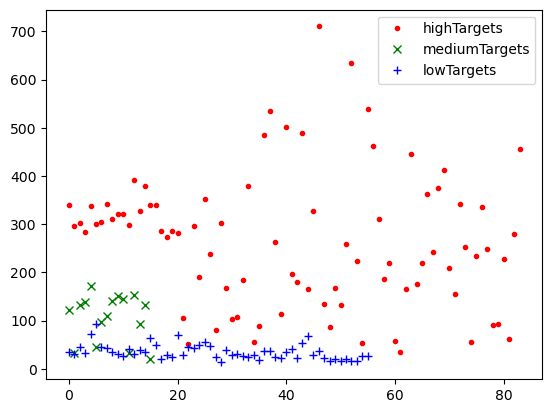

In [13]:
plt.plot(list(range(len(highTargets))), highTargets,
         '.', color='red', label="highTargets")
plt.plot(list(range(len(mediumTargets))), mediumTargets,
         'x', color='green', label="mediumTargets")
plt.plot(list(range(len(lowTargets))), lowTargets,
         '+', color='blue', label="lowTargets")
plt.legend(numpoints=1)
print("High")
printStats(highTargets)
print("Medium")
printStats(mediumTargets)
print("Low")
printStats(lowTargets)

## Working with new data

- ran for 1 hour ~ 72000 frames
<table>
    <tr>
        <td> folder </td><td>total number of files</td>
    </tr>
    <tr>
        <td> 50_nM_AR </td><td>640</td>
    </tr>
    <tr>
        <td> 100_nM_AR </td><td>499</td>
    </tr>
    <tr>
        <td> 400_nM_AR </td><td>477</td>
    </tr>
    <tr>
        <td> 800_nM_AR </td><td>564</td>
    </tr>
    <tr>
        <td> 1200_nM_AR </td><td>794</td>
    </tr>
    <tr>
        <td> 1800_nM_AR </td><td>888</td>
    </tr>
</table>
 <p>Total number of examples <em>3862</em> </p>
 <h3>Each example is <em> one patrical <b>not</b> one experment</em></h3>

In [15]:
datasetLarge = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted/allData/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted/allData/",
    # length=10*oneMinInFPS
)
print(f"datasetLarge:{len(datasetLarge)}")

datasetLarge:3862


Large Dataset
+----------  ----------
| total number of experiments: 3862
| min: 35
| max: 382
| average: 83.42050750906266
| median: 68.0
| mode: ModeResult(mode=51, count=83)
| std: 45.672060431304445
| average difference: 45.66128694559559
+------------------


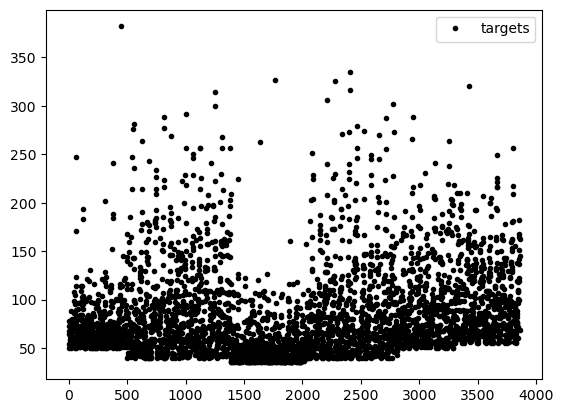

In [16]:
targets = [i[1][0] for i in datasetLarge]
plt.plot(list(range(len(targets))), targets,
         '.', color='black', label="targets")
plt.legend(numpoints=1)
print("Large Dataset")
printStats(targets)

In [17]:
len(datasetLarge[0][0])

100000

In [19]:
length = len(datasetLarge[0][0])
for i in datasetLarge:
    assert len(i[0]) == length

In [18]:
rawData = [datasetLarge[i] for i in list(range(len(datasetLarge)))]


def switchToDurration(expermentFrames):
    lastOne = 0
    for i in range(len(expermentFrames)):
        if expermentFrames[i]:
            expermentFrames[i] = i - lastOne if lastOne != 0 else 0
            lastOne = i
    return expermentFrames


for i in rawData:
    i = (switchToDurration(i[0]), i[1])
print(f"input: {rawData[0][0]}")
print(f"output: {rawData[0][1]}")

input: [0 0 0 ... 0 0 0]
output: [68]


In [11]:
np.max(rawData[0][0])

2990

+----------  ----------
| total number of experiments: 26537
| min: 1
| max: 11904
| average: 1182.0039190564119
| median: 641.0
| mode: ModeResult(mode=2, count=319)
| std: 1494.0991292401238
| average difference: 1390.3879774224142
+------------------


26537

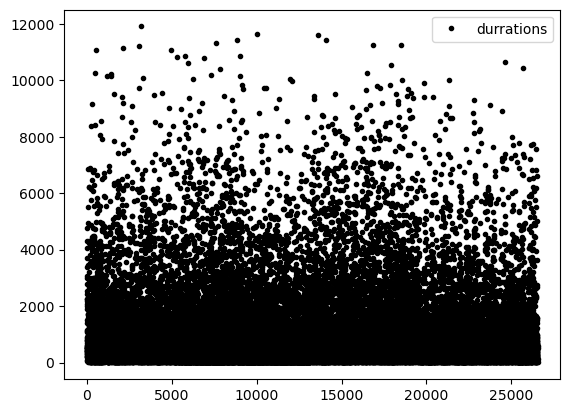

In [12]:
durrations = []
for i in rawData:
    for event in i[0]:
        if event:
            durrations.append(event)
printStats(copy.deepcopy(durrations))
plt.plot(list(range(len(durrations))), durrations,
         '.', color='black', label="durrations")
plt.legend(numpoints=1)
len(durrations)

In [13]:

std_scale = preprocessing.StandardScaler().fit([[i] for i in durrations])
normalized_durrations = std_scale.transform([[i] for i in durrations])
print(len(normalized_durrations))
normalized_durrations = [i[0] for i in normalized_durrations]
normalized_durrations

26537


[1.2100911148131834,
 -0.44508687947273134,
 -0.19744601498191514,
 -0.018743012768272095,
 -0.7596577073394438,
 -0.5555213190429602,
 -0.6545776648392867,
 0.6572496173282802,
 1.2689894825839723,
 0.5407914810542207,
 -0.4839062582307512,
 0.47586941657960136,
 0.8346140202744053,
 -0.5120168428486276,
 0.5883117550511071,
 0.20547236454098042,
 -0.2650452779915704,
 -0.03815270214728202,
 0.7235102810704176,
 -0.21886360326220194,
 1.6866324540495647,
 2.3934128672990296,
 -0.45780357251415166,
 -0.7335550216228442,
 -0.2570136823864628,
 -0.5073317454123148,
 -0.3346524399025025,
 -0.40559820108095257,
 2.0975824291775678,
 -0.07563348163778393,
 -0.4544570743453568,
 -0.6431995710653843,
 -0.27173827432916,
 -0.5876477014633904,
 -0.44307898057145445,
 -0.5996950948710518,
 -0.45780357251415166,
 1.0809162854977037,
 0.15460559237529925,
 0.7141400861977921,
 0.9048904818190965,
 -0.5454818245365758,
 -0.5120168428486276,
 -0.6378451739953126,
 -0.3687867212242096,
 -0.6579241630

/tmp/ipykernel_2263953/2366011641.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


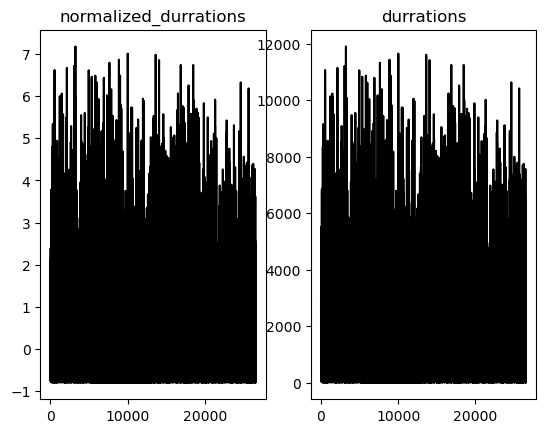

In [14]:
plt.plot(list(range(len(normalized_durrations))), normalized_durrations,
         '.', color='black', label="normalized_durrations")
plt.legend(numpoints=1)

defultePlotSize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [200, 5]
plt.subplot(1, 2, 1)
plt.title('normalized_durrations')
plt.plot(list(range(len(normalized_durrations))),
         normalized_durrations, '-', color='black', )
plt.subplot(1, 2, 2)
plt.title('durrations')
plt.plot(list(range(len(durrations))), durrations, '-', color='black')
plt.rcParams['figure.figsize'] = defultePlotSize

## Baseline estimates via naive approach
----

Small data set

In [15]:
datasetlow = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/low/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/low",
    length=10*oneMinInFPS
)
datasetmedium = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/medium/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/medium",
    length=10*oneMinInFPS
)
datasetHigh = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/high/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/high",
    length=10*oneMinInFPS
)

print(f"datasetlow:{len(datasetlow)}")
print(f"datasetmedium:{len(datasetmedium)}")
print(f"datasetHigh:{len(datasetHigh)}")
print(f"Total: {len(datasetlow) + len(datasetmedium) + len(datasetHigh)}")
rawData = [i for i in datasetlow] + \
    [i for i in datasetmedium] + [i for i in datasetHigh]
print(len(rawData))
rawData[:3]

datasetlow:56
datasetmedium:16
datasetHigh:84
Total: 156
156


[(array([0, 0, 0, ..., 0, 0, 0]), array([34])),
 (array([0, 0, 0, ..., 0, 0, 0]), array([30])),
 (array([0, 0, 0, ..., 0, 0, 0]), array([45]))]

Dumb method is to just assume that the rate of events is constant (i.e. this data has the first half of the experment we will just double the sum of events)

In [16]:
predictions = [np.sum(i[0])*2 for i in rawData]
predictions[:3]

[26, 40, 66]

In [17]:
targets = [i[1][0] for i in rawData]
targets[:3]

[34, 30, 45]

In [18]:
for em in range(21):
    acc = np.isclose(predictions, targets, atol=em)
    print(
        f"accurate within {em} events {int((np.sum(acc)/len(acc))*100)}% of the time")

accurate within 0 events 0% of the time
accurate within 1 events 7% of the time
accurate within 2 events 9% of the time
accurate within 3 events 10% of the time
accurate within 4 events 12% of the time
accurate within 5 events 14% of the time
accurate within 6 events 17% of the time
accurate within 7 events 19% of the time
accurate within 8 events 20% of the time
accurate within 9 events 25% of the time
accurate within 10 events 26% of the time
accurate within 11 events 30% of the time
accurate within 12 events 30% of the time
accurate within 13 events 34% of the time
accurate within 14 events 36% of the time
accurate within 15 events 39% of the time
accurate within 16 events 41% of the time
accurate within 17 events 44% of the time
accurate within 18 events 46% of the time
accurate within 19 events 49% of the time
accurate within 20 events 50% of the time


Large data set

In [19]:
datasetLarge = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/large_dataset/allData/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/large_dataset/allData/",
    length=10*oneMinInFPS
)
print(f"datasetLarge:{len(datasetLarge)}")
rawData = [i for i in datasetLarge]
print(len(rawData))
rawData[:3]

datasetLarge:3862
3862


[(array([0, 0, 0, ..., 0, 0, 0]), array([50])),
 (array([0, 0, 0, ..., 0, 0, 0]), array([79])),
 (array([0, 0, 0, ..., 0, 0, 0]), array([48]))]

In [20]:
predictions = [np.sum(i[0])*6 for i in rawData]
predictions[:3]

[30, 42, 24]

In [21]:
targets = [i[1][0] for i in rawData]
targets[:3]

[50, 79, 48]

In [22]:
for em in range(21):
    acc = np.isclose(predictions, targets, atol=em)
    print(
        f"accurate within {em} events {int((np.sum(acc)/len(acc))*100)}% of the time")

accurate within 0 events 0% of the time
accurate within 1 events 2% of the time
accurate within 2 events 3% of the time
accurate within 3 events 5% of the time
accurate within 4 events 6% of the time
accurate within 5 events 7% of the time
accurate within 6 events 9% of the time
accurate within 7 events 10% of the time
accurate within 8 events 11% of the time
accurate within 9 events 12% of the time
accurate within 10 events 14% of the time
accurate within 11 events 15% of the time
accurate within 12 events 16% of the time
accurate within 13 events 18% of the time
accurate within 14 events 19% of the time
accurate within 15 events 20% of the time
accurate within 16 events 22% of the time
accurate within 17 events 24% of the time
accurate within 18 events 25% of the time
accurate within 19 events 26% of the time
accurate within 20 events 27% of the time


#### working with old data set expect its only the first 3.33 min (200sec)
----

In [23]:
datasetLarge = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/smallData6min/allData/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/smallData6min/allData",
    length=10*oneMinInFPS
)
print(f"datasetLarge:{len(datasetLarge)}")
rawData = [i for i in datasetLarge]
len(rawData[0][0])

datasetLarge:156


4000

#### working with data in seprated folders 
----

In [24]:
# remove first one is it is "/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted"
folders = [d[0] for d in os.walk(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted.back")][1:]
folders

[]

In [25]:
datasets = []
for d in folders:
    datasets.append(expermentDataloader(
        f"{d}/index.csv",
        f"{d}",
        length=10*oneMinInFPS
    ))

In [26]:
colors = ['black', 'brown', 'red', 'darkred', 'olive', 'yellow', 'olivedrab',
          'forestgreen', 'green', 'darkslategray', 'teal', 'slategray', 'midnightblue']
print(len(datasets))
print(len(colors))
# for c in list(mcolors.CSS4_COLORS.keys()):
#     colors.append(c)

0
13


In [27]:
assert (len(colors) >= len(datasets))

In [28]:
defulte_ast_node_interactivity = InteractiveShell.ast_node_interactivity
defultePlotSize = plt.rcParams['figure.figsize']
InteractiveShell.ast_node_interactivity = 'all'
InteractiveShell.ast_node_interactivity

'all'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


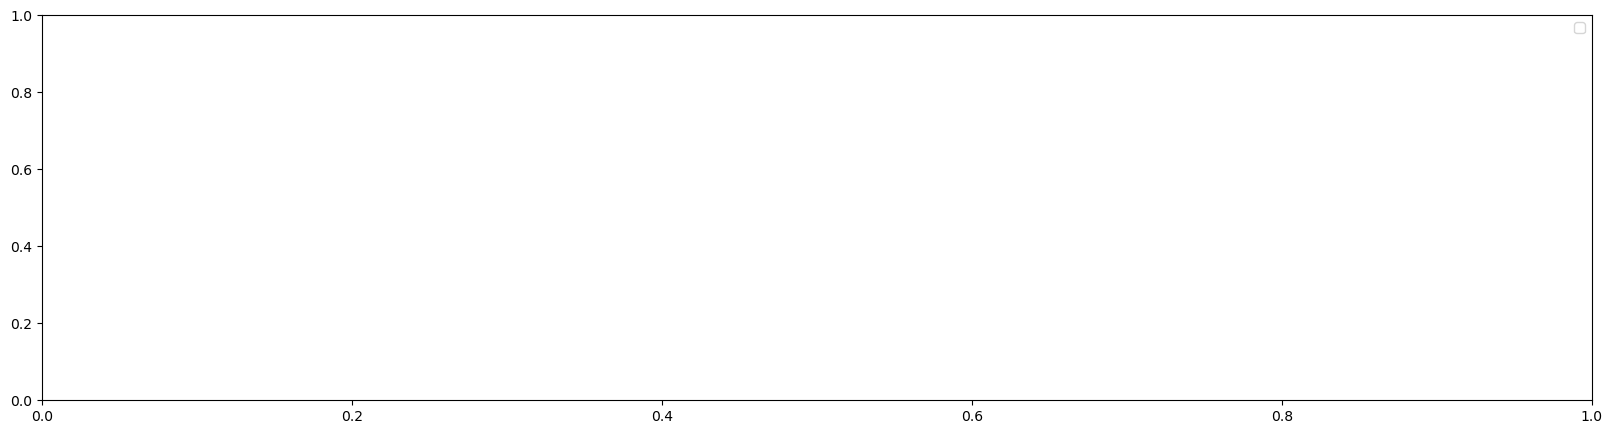

In [29]:
targets = []
for d in datasets:
    targets.append([i[1] for i in d])


plt.rcParams['figure.figsize'] = [20, 5]
for i in range(len(targets)):
    c = colors.pop(random.randrange(len(colors)))
    plt.plot(list(range(len(targets[i]))),
             targets[i], '.', color=c, label=f"dataset {i}")
    print(f"dataset {i}")
    printStats(targets[i])
plt.legend(numpoints=1)

In [30]:
plt.rcParams['figure.figsize'] = defultePlotSize
InteractiveShell.ast_node_interactivity = defulte_ast_node_interactivity

#### finding margin of error
----

In [31]:
# remove first one is it is "/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted"
folders = [d[0] for d in os.walk(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted")][1:]
targets = []
for d in folders:
    data = expermentDataloader(
        f"{d}/index.csv",
        f"{d}",
        length=10*oneMinInFPS
    )
    targets.append([d[1] for d in data])

In [32]:
print(len(targets))
targets

6


[[array([52]),
  array([36]),
  array([41]),
  array([39]),
  array([36]),
  array([37]),
  array([41]),
  array([50]),
  array([42]),
  array([45]),
  array([54]),
  array([36]),
  array([58]),
  array([59]),
  array([65]),
  array([49]),
  array([54]),
  array([73]),
  array([65]),
  array([70]),
  array([92]),
  array([108]),
  array([69]),
  array([50]),
  array([105]),
  array([71]),
  array([71]),
  array([36]),
  array([47]),
  array([44]),
  array([35]),
  array([42]),
  array([37]),
  array([42]),
  array([44]),
  array([53]),
  array([52]),
  array([47]),
  array([52]),
  array([46]),
  array([48]),
  array([47]),
  array([43]),
  array([52]),
  array([58]),
  array([42]),
  array([54]),
  array([53]),
  array([40]),
  array([46]),
  array([35]),
  array([54]),
  array([39]),
  array([106]),
  array([63]),
  array([46]),
  array([74]),
  array([105]),
  array([71]),
  array([126]),
  array([90]),
  array([97]),
  array([122]),
  array([224]),
  array([46]),
  array([36]),
  a

$M.O.E.= z × \frac{σ}{\sqrt{n}}$

In [33]:
σ = np.std(targets[0])
n = len(targets[0])
z = stats.zscore(targets[0])
margin_of_error = z * (σ/np.sqrt(n))
margin_of_error

array([[-0.0623191 ],
       [-0.69477464],
       [-0.49713228],
       [-0.57618922],
       [-0.69477464],
       [-0.65524617],
       [-0.49713228],
       [-0.14137605],
       [-0.45760381],
       [-0.3390184 ],
       [ 0.01673784],
       [-0.69477464],
       [ 0.17485172],
       [ 0.21438019],
       [ 0.45155102],
       [-0.18090452],
       [ 0.01673784],
       [ 0.76777878],
       [ 0.45155102],
       [ 0.64919337],
       [ 1.51881973],
       [ 2.15127526],
       [ 0.6096649 ],
       [-0.14137605],
       [ 2.03268985],
       [ 0.68872184],
       [ 0.68872184],
       [-0.69477464],
       [-0.25996146],
       [-0.37854687],
       [-0.73430311],
       [-0.45760381],
       [-0.65524617],
       [-0.45760381],
       [-0.37854687],
       [-0.02279063],
       [-0.0623191 ],
       [-0.25996146],
       [-0.0623191 ],
       [-0.29948993],
       [-0.22043299],
       [-0.25996146],
       [-0.41807534],
       [-0.0623191 ],
       [ 0.17485172],
       [-0

## looking at raw data in the large dataset to confirm settings

* was it run for an hour?
* was it run at 20 FPS?
* is the data consistent 

In [2]:
large_data_folder = "/home/khood/GitHub/SNN-DNA-project/Prepocessing/large_dataset"
# remove first one is it is "/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted"
folders = [d[0] for d in os.walk(large_data_folder)][1:]
folders.remove(f"{large_data_folder}/allData")
print(len(folders))
folders

6


['/home/khood/GitHub/SNN-DNA-project/Prepocessing/large_dataset/1200_nM_AR',
 '/home/khood/GitHub/SNN-DNA-project/Prepocessing/large_dataset/50_nM_AR',
 '/home/khood/GitHub/SNN-DNA-project/Prepocessing/large_dataset/100_nM_AR',
 '/home/khood/GitHub/SNN-DNA-project/Prepocessing/large_dataset/800_nM_AR',
 '/home/khood/GitHub/SNN-DNA-project/Prepocessing/large_dataset/400_nM_AR',
 '/home/khood/GitHub/SNN-DNA-project/Prepocessing/large_dataset/1800_nM_AR']

In [3]:
allFiles = []
sortedFiles = {}
for d in folders:
    files = os.listdir(d)
    subDir = f"{d.split('/')[-1]}"
    sortedFiles[subDir] = [f"{subDir}/{f}" for f in files]
    files = [f"{subDir}/{f}" for f in files]
    allFiles = allFiles + files

for i in range(len(allFiles)):
    pandasDF = pd.read_excel(os.path.join(
        large_data_folder, allFiles[i]), header=None, names=["Frame Number", "Intesity"])
    frameNumbers = pandasDF.iloc[:, 0]
    allFiles[i] = list(frameNumbers)
for k in sortedFiles.keys():
    for i in range(len(sortedFiles[k])):
        pandasDF = pd.read_excel(os.path.join(
            large_data_folder, sortedFiles[k][i]), header=None, names=["Frame Number", "Intesity"])
        frameNumbers = pandasDF.iloc[:, 0]
        sortedFiles[k][i] = list(frameNumbers)

print(sortedFiles['1800_nM_AR'][0])
print(np.sum([len(sortedFiles[k]) for k in sortedFiles.keys()]))
print(len(allFiles))
allFiles[0]

[245, 1034, 1430, 2434, 4183, 4549, 5680, 6819, 11719, 13147, 14312, 14855, 16215, 16361, 16734, 17007, 17181, 17698, 17816, 19274, 20562, 20725, 20796, 22581, 24554, 25905, 26491, 27005, 27625, 28227, 30557, 30613, 31200, 33135, 35304, 35505, 35833, 35924, 36781, 36877, 36877, 37588, 37711, 39302, 39432, 40284, 40835, 41810, 41857, 42119, 42304, 42690, 44003, 44328, 45008, 45405, 45904, 48080, 49035, 49686, 50738, 52422, 52683, 53839, 54120, 54443, 54757, 54818, 54975, 55605, 56987, 57459, 57677, 58101, 58607, 58753, 59844, 60350, 60394, 60841, 61224, 61226, 63001, 63102, 65882, 66238, 67016, 68409, 68472, 68582, 68664, 69484, 69648, 69721, 70040, 70100, 70197, 70636, 71173, 72106, 72413, 72445, 72652, 72994, 73677, 73846, 76809, 77893, 78078, 80530, 82110, 82364, 82948, 83560, 83643, 83894, 86041, 86339, 86846, 87038, 87302, 87666, 87968, 89201, 90467, 91629, 92827, 93057, 93302, 93527, 93605, 94814, 95520, 96231, 96626, 97631, 97734, 97762, 98283, 98784, 98870, 99043, 99224, 99690]


[6210,
 9200,
 9717,
 10604,
 11758,
 12299,
 12316,
 13114,
 22596,
 22815,
 22890,
 24538,
 26665,
 29818,
 37259,
 39145,
 39737,
 41738,
 42194,
 42897,
 52989,
 53463,
 54864,
 58767,
 59274,
 70396,
 70708,
 70722,
 70885,
 70957,
 71161,
 74625,
 76181,
 76374,
 76859,
 77517,
 78729,
 78956,
 79137,
 81242,
 82276,
 86982,
 87010,
 87031,
 90977,
 94334,
 94938,
 96828,
 96982,
 99558]

In [4]:
sortedFiles[k]

[[245,
  1034,
  1430,
  2434,
  4183,
  4549,
  5680,
  6819,
  11719,
  13147,
  14312,
  14855,
  16215,
  16361,
  16734,
  17007,
  17181,
  17698,
  17816,
  19274,
  20562,
  20725,
  20796,
  22581,
  24554,
  25905,
  26491,
  27005,
  27625,
  28227,
  30557,
  30613,
  31200,
  33135,
  35304,
  35505,
  35833,
  35924,
  36781,
  36877,
  36877,
  37588,
  37711,
  39302,
  39432,
  40284,
  40835,
  41810,
  41857,
  42119,
  42304,
  42690,
  44003,
  44328,
  45008,
  45405,
  45904,
  48080,
  49035,
  49686,
  50738,
  52422,
  52683,
  53839,
  54120,
  54443,
  54757,
  54818,
  54975,
  55605,
  56987,
  57459,
  57677,
  58101,
  58607,
  58753,
  59844,
  60350,
  60394,
  60841,
  61224,
  61226,
  63001,
  63102,
  65882,
  66238,
  67016,
  68409,
  68472,
  68582,
  68664,
  69484,
  69648,
  69721,
  70040,
  70100,
  70197,
  70636,
  71173,
  72106,
  72413,
  72445,
  72652,
  72994,
  73677,
  73846,
  76809,
  77893,
  78078,
  80530,
  82110,
  82364,
 

In [5]:
allFiles[0]

[6210,
 9200,
 9717,
 10604,
 11758,
 12299,
 12316,
 13114,
 22596,
 22815,
 22890,
 24538,
 26665,
 29818,
 37259,
 39145,
 39737,
 41738,
 42194,
 42897,
 52989,
 53463,
 54864,
 58767,
 59274,
 70396,
 70708,
 70722,
 70885,
 70957,
 71161,
 74625,
 76181,
 76374,
 76859,
 77517,
 78729,
 78956,
 79137,
 81242,
 82276,
 86982,
 87010,
 87031,
 90977,
 94334,
 94938,
 96828,
 96982,
 99558]

In [6]:
lengths = [f[-1] for f in allFiles]

In [7]:
lengths

[99558,
 97822,
 96475,
 99858,
 97611,
 98944,
 93411,
 99882,
 98519,
 98395,
 99298,
 99769,
 97369,
 99599,
 99202,
 92901,
 99579,
 99951,
 99607,
 99611,
 99868,
 99393,
 97115,
 99896,
 92987,
 98159,
 99722,
 99435,
 99927,
 99547,
 99909,
 99385,
 99714,
 93693,
 99756,
 98866,
 99215,
 97757,
 99460,
 99783,
 99521,
 99689,
 99486,
 99753,
 99843,
 99407,
 94270,
 99559,
 99996,
 86397,
 99634,
 99687,
 98357,
 99599,
 95314,
 98290,
 99387,
 96165,
 97783,
 96298,
 95734,
 98559,
 97781,
 89939,
 97559,
 98244,
 99885,
 93393,
 99758,
 99732,
 97732,
 99765,
 96643,
 99941,
 99788,
 99922,
 89005,
 99322,
 99960,
 99187,
 96139,
 95724,
 98485,
 95077,
 99901,
 99057,
 99672,
 97388,
 99378,
 98623,
 98899,
 99119,
 97414,
 99936,
 98478,
 96059,
 96522,
 99641,
 99310,
 99772,
 99125,
 97701,
 99967,
 95871,
 99376,
 98281,
 98835,
 99888,
 99501,
 99818,
 97839,
 94194,
 97814,
 97055,
 96933,
 96821,
 99865,
 93409,
 99065,
 99659,
 98209,
 98497,
 99854,
 97865,
 98734,


In [8]:
printStats(lengths)

+----------  ----------
| total number of experiments: 3862
| min: 19386
| max: 99999
| average: 97817.18436043501
| median: 99095.0
| mode: ModeResult(mode=99894, count=10)
| std: 4080.2525449839623
| average difference: 2884.8665904554045
+------------------


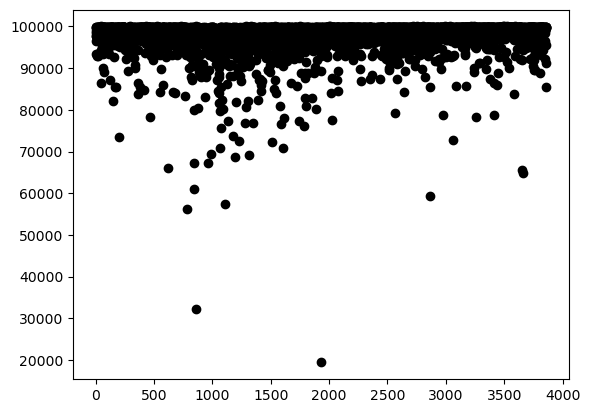

In [9]:
plt.plot(list(range(len(lengths))), lengths, 'o', color='black')

In [50]:
large_data_folder = "/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted"
# remove first one is it is "/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted"
folders = [d[0] for d in os.walk(large_data_folder)][1:]
folders.remove(
    '/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted/allData')
# folders.remove(f"{large_data_folder}/allData")
print(len(folders))
folders

6


['/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted/50_nM_AR_5000',
 '/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted/100_nM_AR_5000',
 '/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted/1800_nM_AR_5000',
 '/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted/800_nM_AR_5000',
 '/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted/1200_nM_AR_5000',
 '/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted/400_nM_AR_5000']

In [51]:
datasets = []
featIn = 0
rawData = {}
for d in folders:
    data = expermentDataloader(
        f"{d}/index.csv",
        f"{d}",
        length=oneMinInFPS
    )
    rawData[f"{d.split('/')[-1]}"] = [d for d in data]
rawData.keys()

dict_keys(['50_nM_AR_5000', '100_nM_AR_5000', '1800_nM_AR_5000', '800_nM_AR_5000', '1200_nM_AR_5000', '400_nM_AR_5000'])

In [52]:
data = [list(d[0]) for d in rawData["50_nM_AR_5000"]]

In [53]:
targets = [list(d[1]) for d in rawData["50_nM_AR_5000"]]
np.sum(targets)

34289

In [54]:
len(rawData)

6

In [55]:
dfs = {}
for k in rawData.keys():
    data = [list(d[0]) for d in rawData[k]]
    df = pd.DataFrame(data)
    df = df.sum(axis=0)
    # df = df.sub(np.mean(data))
    df = [list(df)]
    dfs[k] = pd.DataFrame(df)

In [56]:
sums = []
for i in data:
    sums.append(sum(i))

sumOccurrences = {}
for i in sums:
    if f'{i}' in sumOccurrences.keys():
        sumOccurrences[f'{i}'] = sumOccurrences[f'{i}'] + 1
    else:
        sumOccurrences[f'{i}'] = 1
sumOccurrences

{'1': 183, '3': 29, '0': 170, '2': 72, '4': 15, '5': 8}

In [57]:
dfs[k]

,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,2,1,1,0,0,0,2,0,1,1,...,0,1,0,0,1,0,0,0,1,0


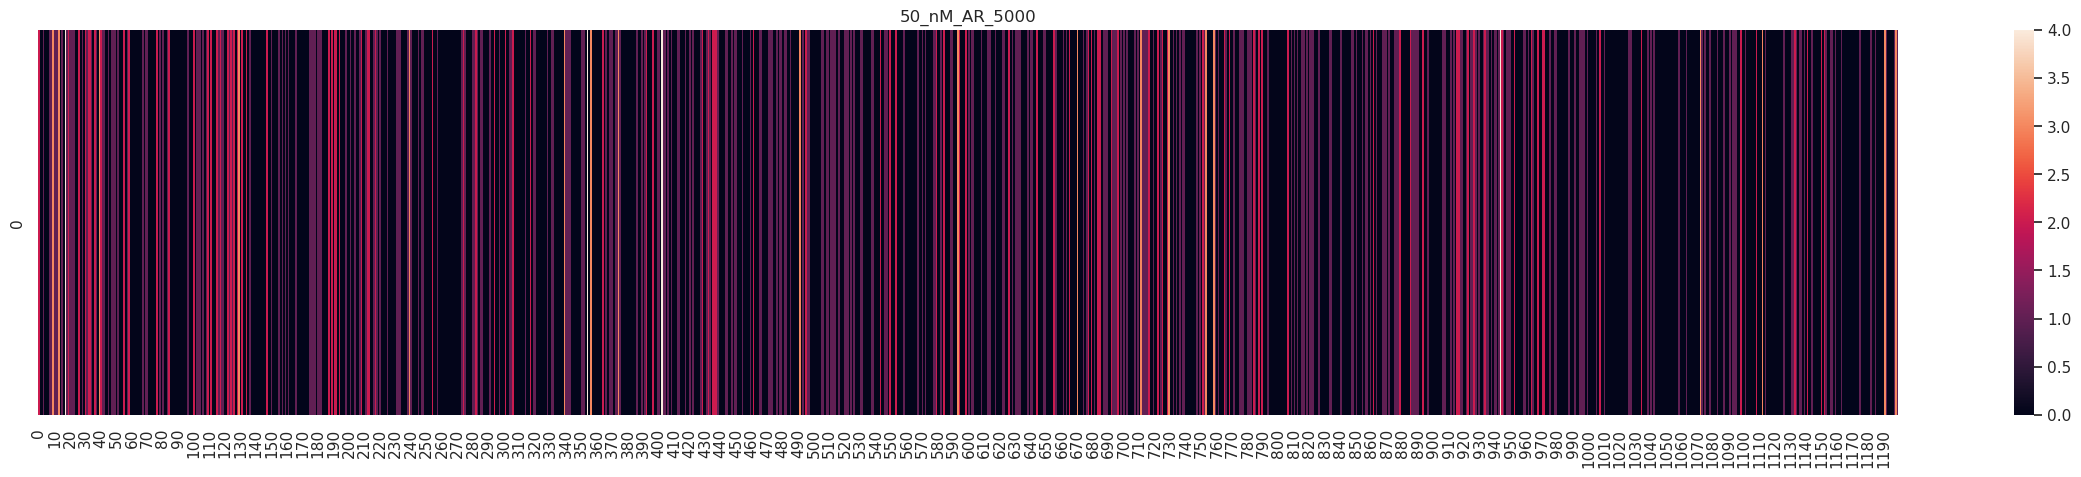

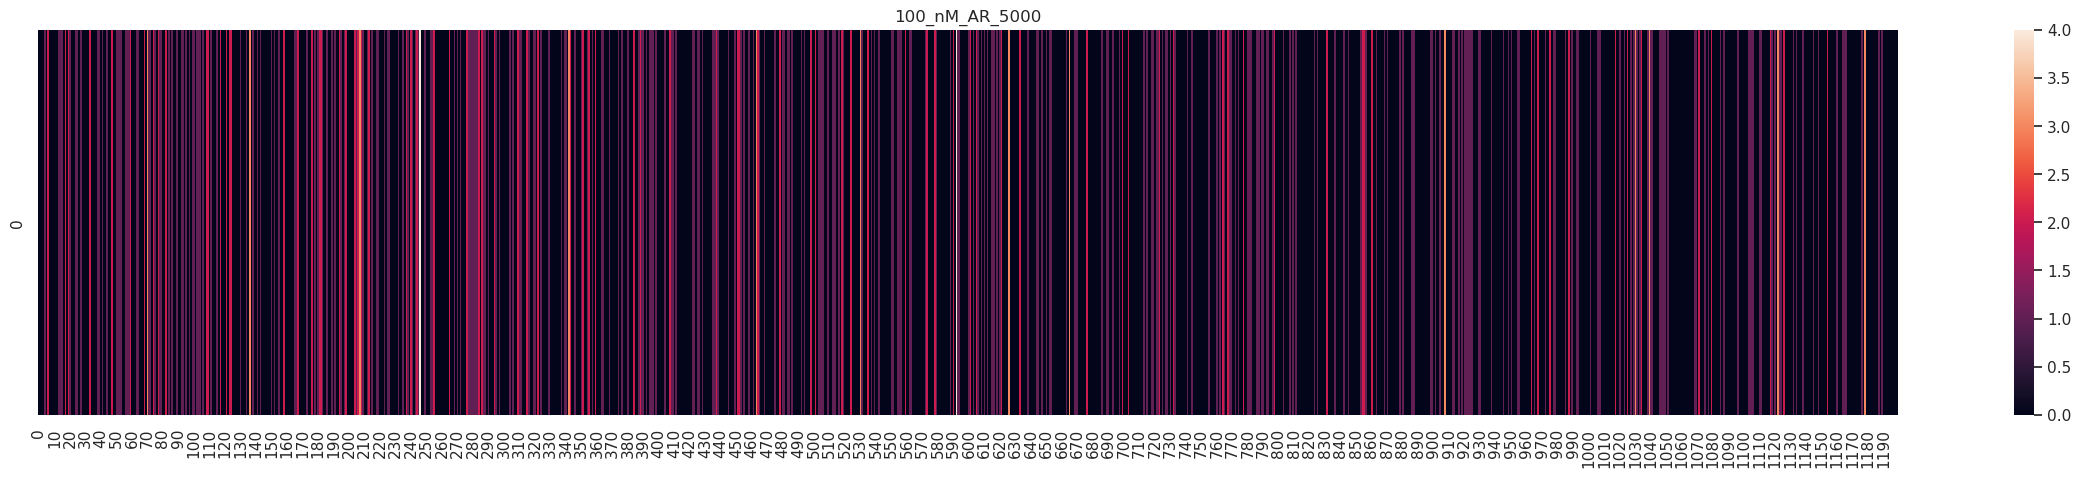

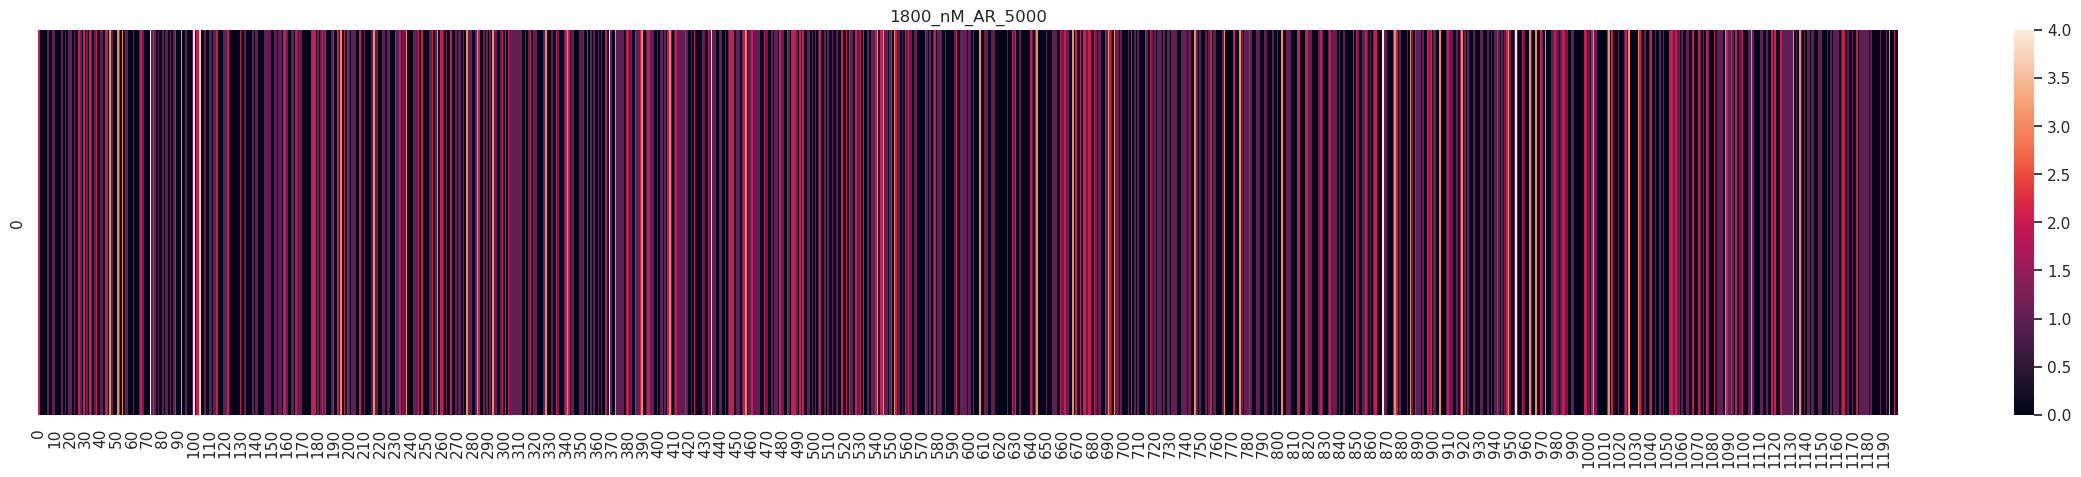

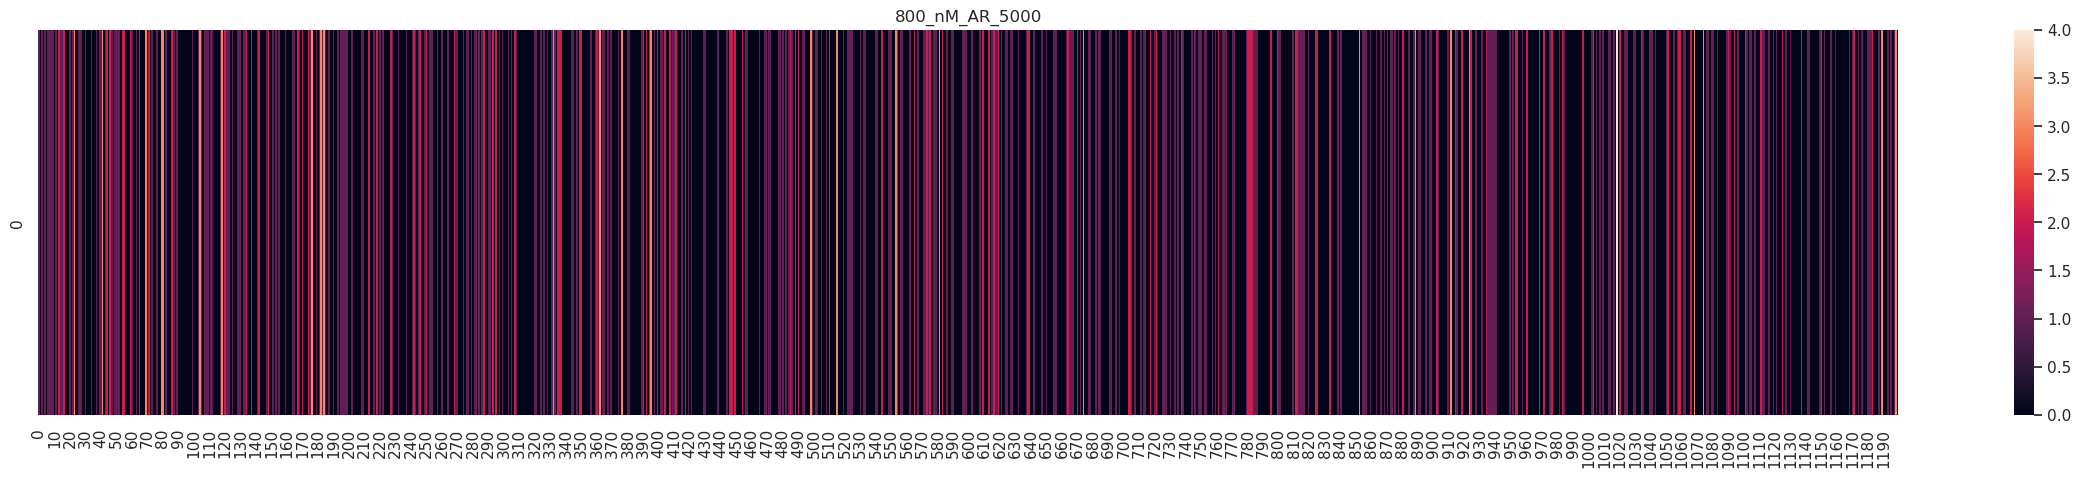

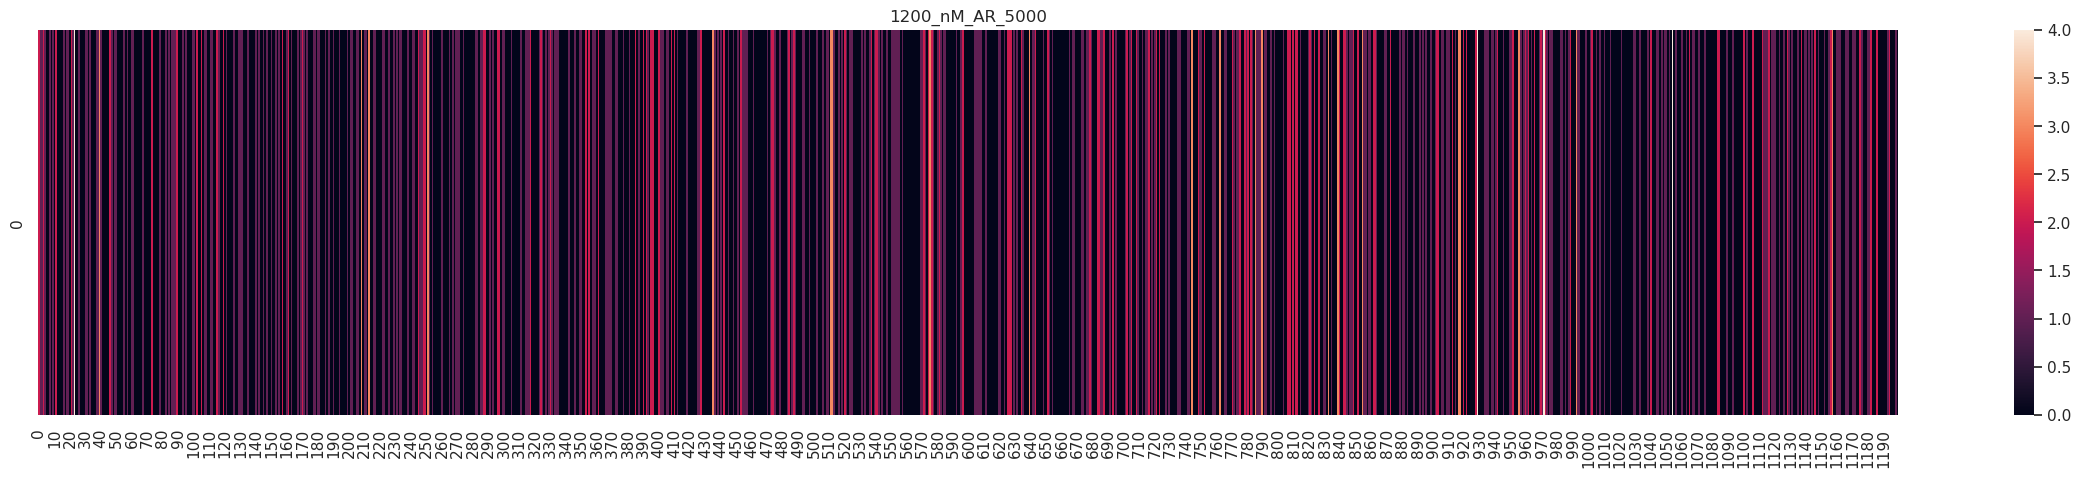

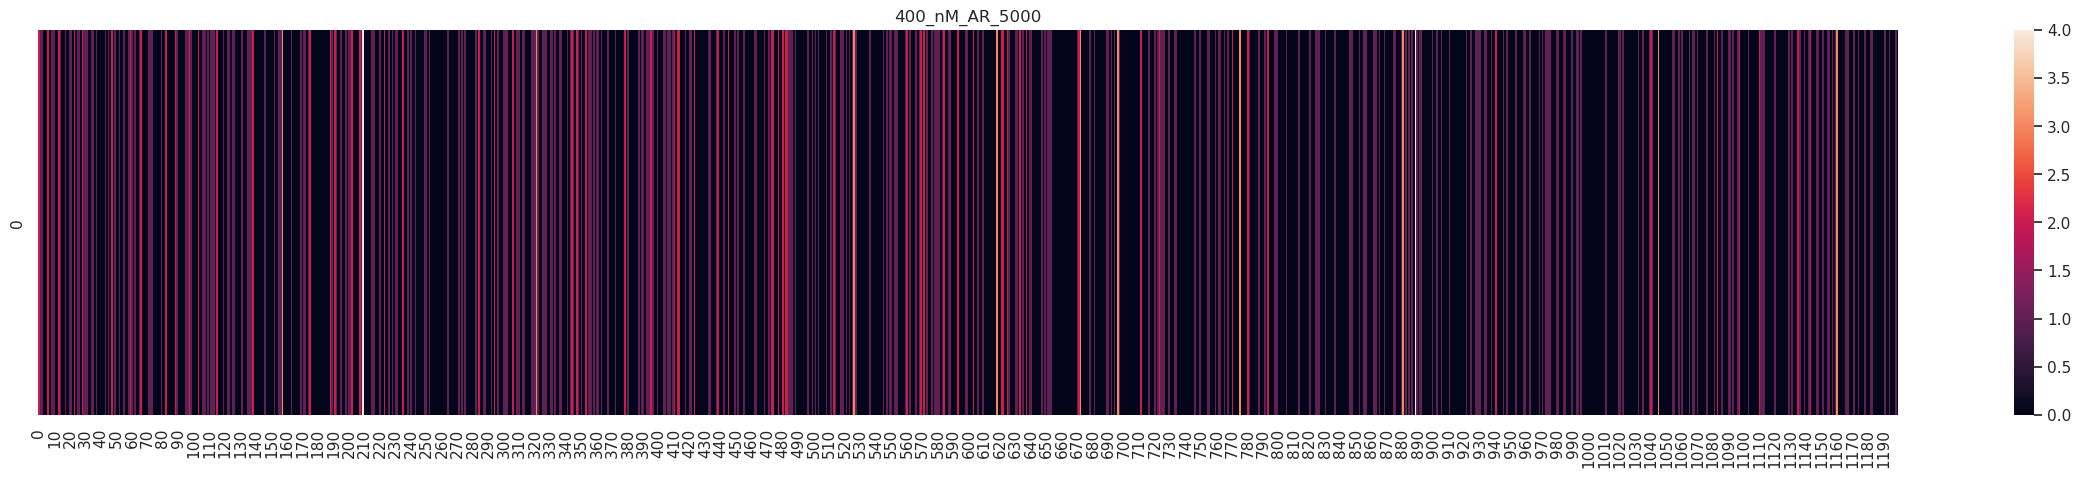

In [58]:
for k in dfs.keys():
    plt.rcParams['figure.figsize'] = [30, 5]
    sns
    sns.set(style="darkgrid")
    sns.heatmap(data=dfs[k])
    plt.title(f'{k}')
    plt.show()